In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

from modules import f1_metric

In [2]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False,
                                                               weights="imagenet",
                                                               input_shape=img_shape, pooling='max')


model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(512, kernel_regularizer=regularizers.l2(0.016),
               activity_regularizer=regularizers.l1(0.006),
               bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.5, seed=123),
    Dense(2, activation= 'softmax')])

model.load_weights('./output/best/model_weights.h5')

model.compile(Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics= [tf.keras.metrics.FalseNegatives(name='FN'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(curve='PR', name='pr_auc'),
                        f1_metric.F1Score(),
                        'accuracy'])

In [3]:
df = pd.read_csv("E:/vindr_mammo/Data/full_df.csv")
df['image_path'] = 'E:/vindr_mammo/Data/png/' + df['study_id'] + '/' + df['image_id'] + '.png'
df['label'] = df['breast_birads'].map({'BI-RADS 1': '0',
                                       'BI-RADS 2': '0',
                                       'BI-RADS 3': '1',
                                       'BI-RADS 4': '1',
                                       'BI-RADS 5': '1'})
train_df = df[df['split'] == 'training']
tmp_test_df = df[df['split'] == 'test']
test_df, val_df = train_test_split(tmp_test_df, test_size=0.5, stratify=tmp_test_df['label'], random_state=42)

In [4]:
# Load and preprocess the single image
indx = 0
img_path = test_df['image_path'].to_list()[indx]
print(img_path)
img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)  # Specify the target size as expected by the model
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

E:/vindr_mammo/Data/png/b2979c0f7fa4edae4a174b0747e0ab37/c8d0f2ace6a0b244914bfeccaa0d50ff.png


In [5]:
# Make predictions
predictions = model.predict(img_array)
predictions

1/1 [==============================] - 2s 2s/step


array([[0.09703927, 0.9029607 ]], dtype=float32)

Class 1
Real class: 1


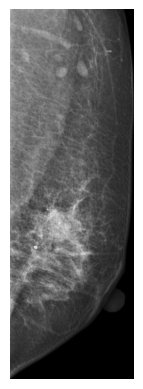

In [6]:
if predictions[0][1] > 0.5:
    print("Class 1")
else:
    print("Class 0")
print("Real class:", test_df['label'].to_list()[indx])
plt.imshow(tf.keras.preprocessing.image.load_img(img_path))
plt.axis('off')  # Turn off axis labels
plt.show()